In [424]:
import pandas as pd
from scipy.io.arff import loadarff

In [425]:
data = []
with open('/Users/itsmine/Documents/3DA3/A6/chronic_kidney_disease_full.arff', "r") as f:
    for line in f:
        line = line.replace('\n', '')
        data.append(line.split(','))


names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu',  'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
         'class', 'no_name']
    
df = pd.DataFrame(data[145:], columns=names)

In [426]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.cm as cm

from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis
from sklearn import neighbors
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from patsy import dmatrices, dmatrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import silhouette_samples, silhouette_score


## 1. Classification Problem Identification

In the medical field, the diagnosis of a disease can often depend on the patient's physical indicators. Just like in this case, whether a patient has chronic kidney disease depends on many physical indicators like bp, bu,pcc, and so on. Now we contain a large amount of data for those indicators. In this project, we will use the data we have to train some modeling algorithms based on some of the significant indicators of a patient, and then predict whether a patient has chronic kidney disease based on the variables we chose.

## 2. Variable Transformation

In [427]:
df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,no_name
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,7800,5.2,yes,yes,no,good,no,no,ckd,None
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,6000,?,no,no,no,good,no,no,ckd,None
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,7500,?,no,yes,no,poor,no,yes,ckd,None
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,6700,3.9,yes,no,no,poor,yes,yes,ckd,None
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,7300,4.6,no,no,no,good,no,no,ckd,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,12,80,1.020,0,0,normal,normal,notpresent,notpresent,100,...,6600,5.4,no,no,no,good,no,no,notckd,None
398,17,60,1.025,0,0,normal,normal,notpresent,notpresent,114,...,7200,5.9,no,no,no,good,no,no,notckd,None
399,58,80,1.025,0,0,normal,normal,notpresent,notpresent,131,...,6800,6.1,no,no,no,good,no,no,notckd,None
400,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


Through initial exploration, we found that there are many categorical variables in this data set, so we need to datamaterialize these variables before calculation. For example, we use 1 for "yes" and 0 for "no".

In [428]:
transform = {
    "rbc": {'normal':1, 'abnormal':0},
    "pc": {'normal':1, 'abnormal':0},
    "pcc": {'present':1, 'notpresent':0},
    "ba": {'present':1, 'notpresent':0},
    "htn": {'yes':1, 'no':0},
    "dm": {'yes':1, 'no':0},
    "cad": {'yes':1, 'no':0},
    "appet": {'good':1, 'poor':0},
    "pe": {'yes':1, 'no':0},
    "ane": {'yes':1, 'no':0},
}

In [429]:
df.replace(transform, inplace=True)
df = df.drop('no_name', axis=1)
df = df[:400] #because the last 2 rows record nothing, so we can just drop them
df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
count,400,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,400
unique,77,11,6,7,7,3,3,3,3,147,...,45,93,50,3,7,4,4,4,3,4
top,60,80,1.020,0,0,1,1,0,0,?,...,?,?,?,0,0,0,1,0,0,ckd
freq,19,116,106,199,290,201,259,354,374,44,...,70,105,130,251,257,362,316,322,339,248


## 3. Dataset Overview

In [430]:
df.isna().any()

age      False
bp       False
sg       False
al       False
su       False
rbc      False
pc       False
pcc      False
ba       False
bgr      False
bu       False
sc       False
sod      False
pot      False
hemo     False
pcv      False
wbcc     False
rbcc     False
htn      False
dm       False
cad      False
appet    False
pe       False
ane      False
class    False
dtype: bool

In [431]:
df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
count,400,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,400
unique,77,11,6,7,7,3,3,3,3,147,...,45,93,50,3,7,4,4,4,3,4
top,60,80,1.020,0,0,1,1,0,0,?,...,?,?,?,0,0,0,1,0,0,ckd
freq,19,116,106,199,290,201,259,354,374,44,...,70,105,130,251,257,362,316,322,339,248


1. There are 400 observations in the dataset;

2. There exist missing values in all the variables besides "age" variable;

3. "htn","dm","cad","appet","pe","ane","class" are categorical variable. In the variable description, they are binary. But they are found that some elements are mis-recording;

## 4. Association Between Variables

In [432]:
df.replace('?', pd.NA, inplace=True)

In [433]:
df.shape
# there are 400 observations

(400, 25)

In [434]:
df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
count,391,388,353,354,351,248,335,396,396,356,...,330,295,270,398,398,398,399,399,399,400
unique,76,10,5,6,6,2,2,2,2,146,...,44,92,49,2,6,3,3,3,2,4
top,60,80,1.020,0,0,1,1,0,0,99,...,41,9800,5.2,0,0,0,1,0,0,ckd
freq,19,116,106,199,290,201,259,354,374,10,...,21,11,18,251,257,362,316,322,339,248


In [435]:
columns_to_convert = df.columns.difference(['class'])  # 选择除了'class'列外的所有列
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
rbc      float64
pc       float64
pcc      float64
ba       float64
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
htn      float64
dm       float64
cad      float64
appet    float64
pe       float64
ane      float64
class     object
dtype: object

In [436]:
numerical = ["age",'bp','bgr','bu','sc','sod','pot','hemo','pcv','wbcc','rbcc']
df_numerical = df[numerical]

In [437]:
categorical = ["sg",'al','su','rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
df_categorical = df[categorical]

In [438]:
df_numerical.isnull().any()

age     True
bp      True
bgr     True
bu      True
sc      True
sod     True
pot     True
hemo    True
pcv     True
wbcc    True
rbcc    True
dtype: bool

<Axes: >

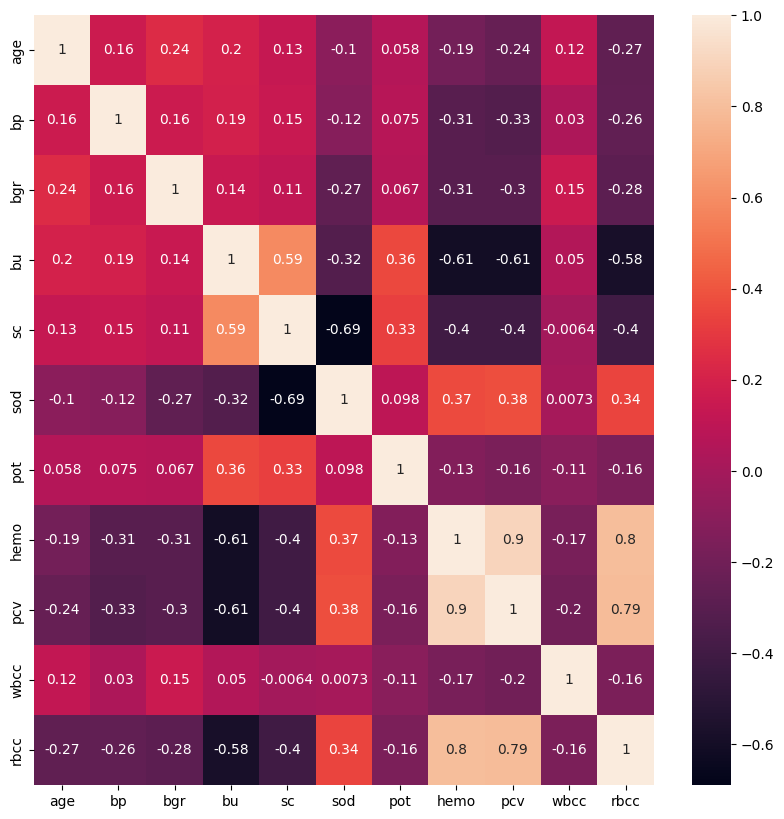

In [439]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_numerical.corr(),annot=True)

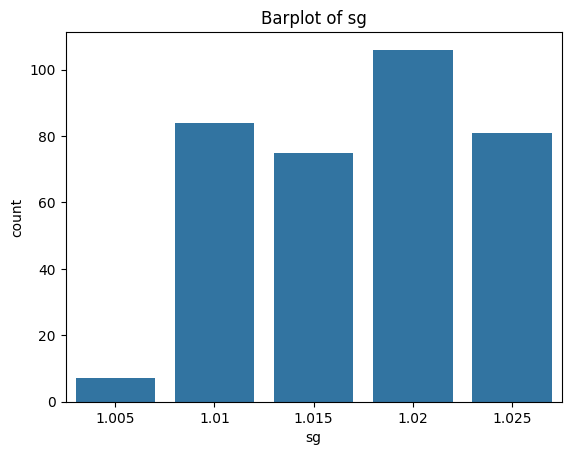

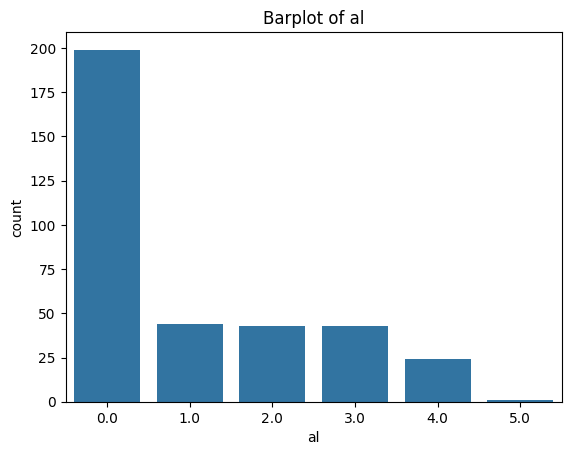

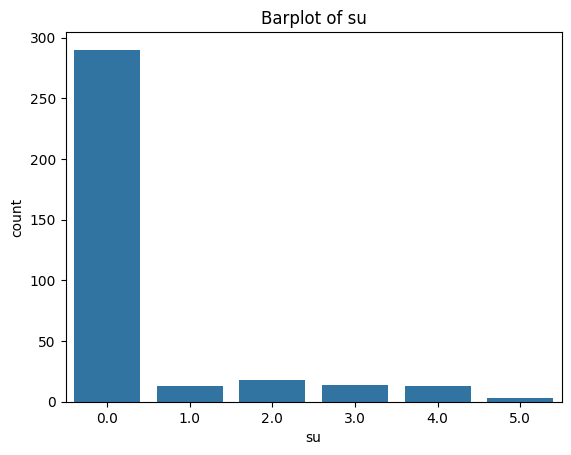

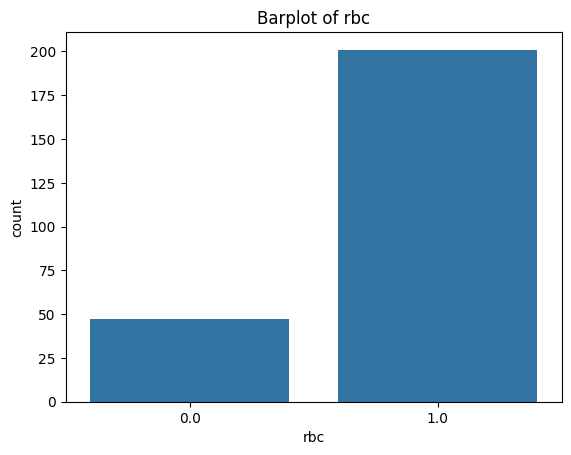

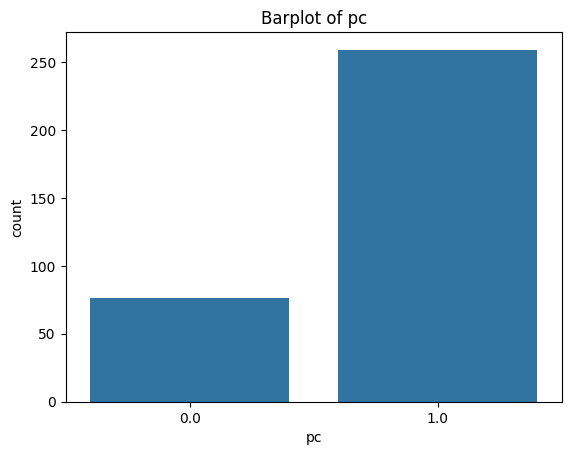

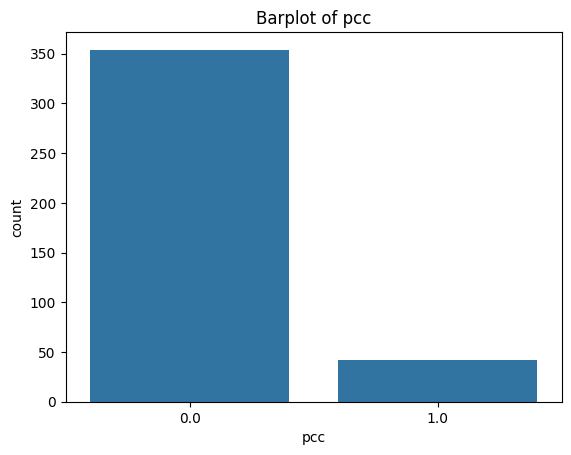

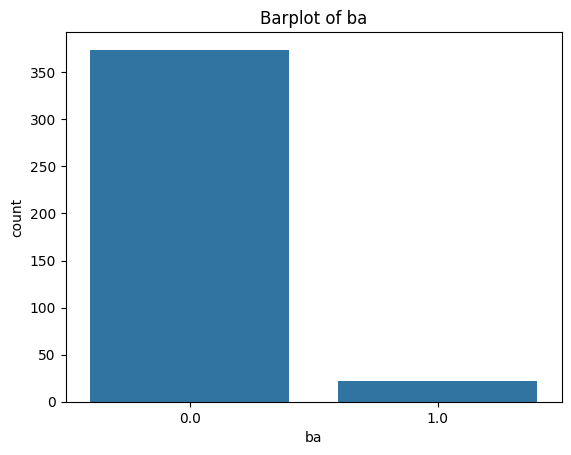

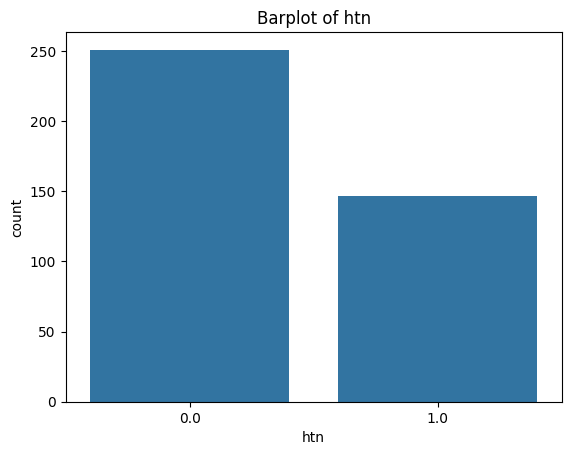

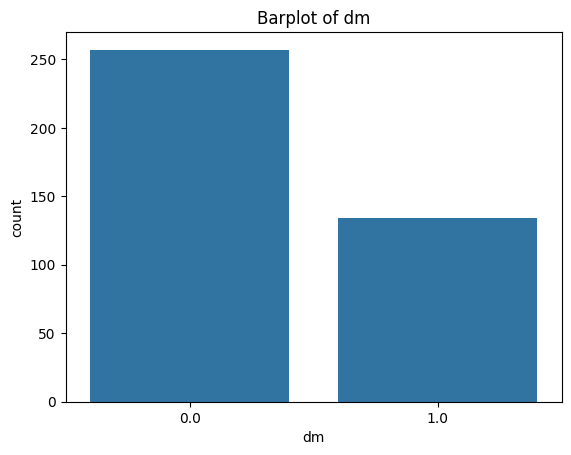

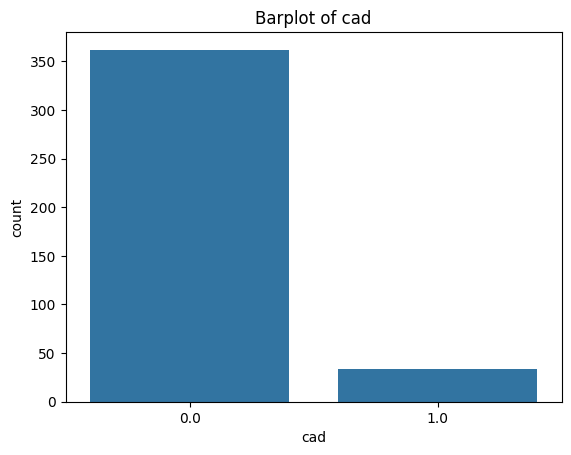

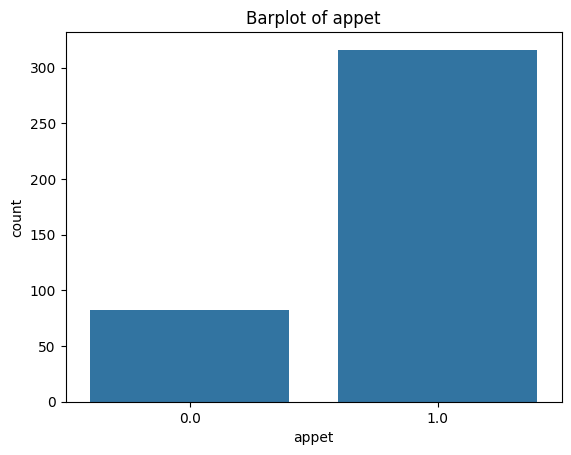

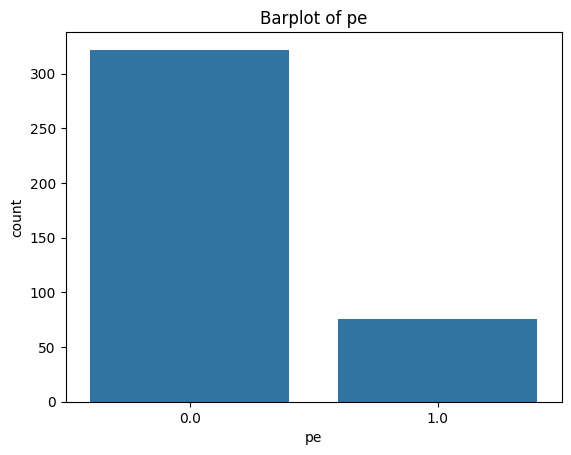

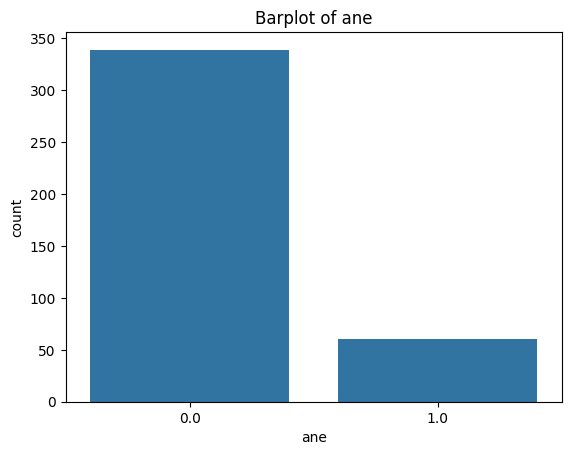

In [440]:
for column in df_categorical.columns:
    plt.figure()  # 创建一个新的图形
    sns.countplot(x=column, data=df_categorical)  # 使用countplot()绘制柱状图
    plt.title(f'Barplot of {column}')  # 设置图形标题
    plt.show()  # 显示图形

1. "rbcc" and "hemo", "pcv" have strong positive correlation;
2. "al" and "hemo", "pcv" have strong negetive correlation;
3. "pot" has compartively weak correlation to most of variables.

## 5. Missing Value Analysis and Handling

In [441]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         9
cad        4
appet      2
pe         2
ane        1
class      0
dtype: int64

If the variable contains way too many missing variables we will drop it because it will cause the sample size small, and most likely will not be significant to the model, even though in some cases that variable can be still significant, However smaller the sample size less possibility it will happen. Thus we set if the number of the missing value is more than 10 percent, we decide to drop the variable.

To guarantee the accuracy of the model, we decided to fill up the missing value for the variable we didn't drop. We used median to filled up continuous variables, and used mode to fill up categorical variables

In [442]:
missing_counts = df.isnull().sum()

In [443]:
variables_drop = missing_counts[missing_counts > 40].index
df = df.drop(columns=variables_drop)
print(df.columns)

Index(['age', 'bp', 'pcc', 'ba', 'bu', 'sc', 'htn', 'dm', 'cad', 'appet', 'pe',
       'ane', 'class'],
      dtype='object')


In [444]:
df.isnull().any()
# Missing values still exist

age       True
bp        True
pcc       True
ba        True
bu        True
sc        True
htn       True
dm        True
cad       True
appet     True
pe        True
ane       True
class    False
dtype: bool

In [445]:
numerical = ["age",'bp','bu','sc']
df_numerical = df[numerical]

In [446]:
df_numerical = df_numerical.fillna(df_numerical.median())
df_numerical.isnull().any()

age    False
bp     False
bu     False
sc     False
dtype: bool

In [447]:
for column in numerical:
    mean_value = df[column].median()
    df[column].fillna(mean_value, inplace=True)

df

,age,bp,pcc,ba,bu,sc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,0.0,0.0,36.0,1.2,1.0,1.0,0.0,1.0,0.0,0.0,ckd
1,7.0,50.0,0.0,0.0,18.0,0.8,0.0,0.0,0.0,1.0,0.0,0.0,ckd
2,62.0,80.0,0.0,0.0,53.0,1.8,0.0,1.0,0.0,0.0,0.0,1.0,ckd
3,48.0,70.0,1.0,0.0,56.0,3.8,1.0,0.0,0.0,0.0,1.0,1.0,ckd
4,51.0,80.0,0.0,0.0,26.0,1.4,0.0,0.0,0.0,1.0,0.0,0.0,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,0.0,0.0,49.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,notckd
396,42.0,70.0,0.0,0.0,31.0,1.2,0.0,0.0,0.0,1.0,0.0,0.0,notckd
397,12.0,80.0,0.0,0.0,26.0,0.6,0.0,0.0,0.0,1.0,0.0,0.0,notckd
398,17.0,60.0,0.0,0.0,50.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,notckd


In [448]:
categorical = ["pcc","ba",'htn','dm','cad','appet','pe','ane']
df_categorical = df[categorical]
df_categorical.isnull().any()

pcc      True
ba       True
htn      True
dm       True
cad      True
appet    True
pe       True
ane      True
dtype: bool

In [449]:
df_categorical = df_categorical.fillna(df_categorical.mode().iloc[0])
df_categorical.isnull().any()

pcc      False
ba       False
htn      False
dm       False
cad      False
appet    False
pe       False
ane      False
dtype: bool

In [450]:
df[categorical] = df[categorical].fillna(df[categorical].mode().iloc[0])

In [451]:
df["class"].unique()

array(['ckd', 'ckd\t', 'notckd', 'no'], dtype=object)

In [452]:
df = df[df['class'] != 'ckd\t']
df.replace('no','notckd', inplace=True)
df["class"].unique()

/var/folders/81/yhrrszz97gz7w6ntdbgvchq80000gn/T/ipykernel_39441/2249324948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('no','notckd', inplace=True)


array(['ckd', 'notckd'], dtype=object)

In [453]:
df.isna().any()

age      False
bp       False
pcc      False
ba       False
bu       False
sc       False
htn      False
dm       False
cad      False
appet    False
pe       False
ane      False
class    False
dtype: bool

## 6. Outlier Analysis

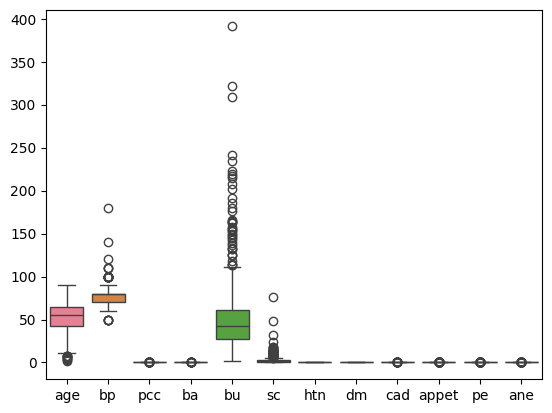

In [454]:
df_for_outliers = df.drop('class',axis=1)
sns.boxplot(data=df_for_outliers)

plt.show()

From this plot, we have found that most of predict variables contain outliers. In the original dataset, we should not make changes because these data are objective. However, before training the model, we can standardize these data

In [455]:
scaler = StandardScaler()

df[numerical] = scaler.fit_transform(df[numerical])

/var/folders/81/yhrrszz97gz7w6ntdbgvchq80000gn/T/ipykernel_39441/4006521348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical] = scaler.fit_transform(df[numerical])


## 7. Sub-group Analysis

In [456]:
df_x = df.drop('class',axis=1)
df_x

,age,bp,pcc,ba,bu,sc,htn,dm,cad,appet,pe,ane
0,-0.205036,0.251629,0.0,0.0,-0.420352,-0.319290,1.0,1.0,0.0,1.0,0.0,0.0
1,-2.622511,-1.973889,0.0,0.0,-0.784611,-0.390268,0.0,0.0,0.0,1.0,0.0,0.0
2,0.620443,0.251629,0.0,0.0,-0.076330,-0.212823,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.205036,-0.490210,1.0,0.0,-0.015620,0.142068,1.0,0.0,0.0,0.0,1.0,1.0
4,-0.028148,0.251629,0.0,0.0,-0.622718,-0.283801,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.207703,0.251629,0.0,0.0,-0.157276,-0.443502,0.0,0.0,0.0,1.0,0.0,0.0
396,-0.558813,-0.490210,0.0,0.0,-0.521535,-0.319290,0.0,0.0,0.0,1.0,0.0,0.0
397,-2.327697,0.251629,0.0,0.0,-0.622718,-0.425757,0.0,0.0,0.0,1.0,0.0,0.0
398,-2.032883,-1.232049,0.0,0.0,-0.137039,-0.354779,0.0,0.0,0.0,1.0,0.0,0.0


In [457]:
df_x.var()

age      1.002519
bp       1.002519
pcc      0.092636
ba       0.052352
bu       1.002519
sc       1.002519
htn      0.232175
dm       0.222219
cad      0.078326
appet    0.161007
pe       0.154880
ane      0.126584
dtype: float64

In [458]:
scaler_df = df_x[["age", 'bp', 'bu', 'sc']]
scaler_df

,age,bp,bu,sc
0,-0.205036,0.251629,-0.420352,-0.319290
1,-2.622511,-1.973889,-0.784611,-0.390268
2,0.620443,0.251629,-0.076330,-0.212823
3,-0.205036,-0.490210,-0.015620,0.142068
4,-0.028148,0.251629,-0.622718,-0.283801
...,...,...,...,...
395,0.207703,0.251629,-0.157276,-0.443502
396,-0.558813,-0.490210,-0.521535,-0.319290
397,-2.327697,0.251629,-0.622718,-0.425757
398,-2.032883,-1.232049,-0.137039,-0.354779


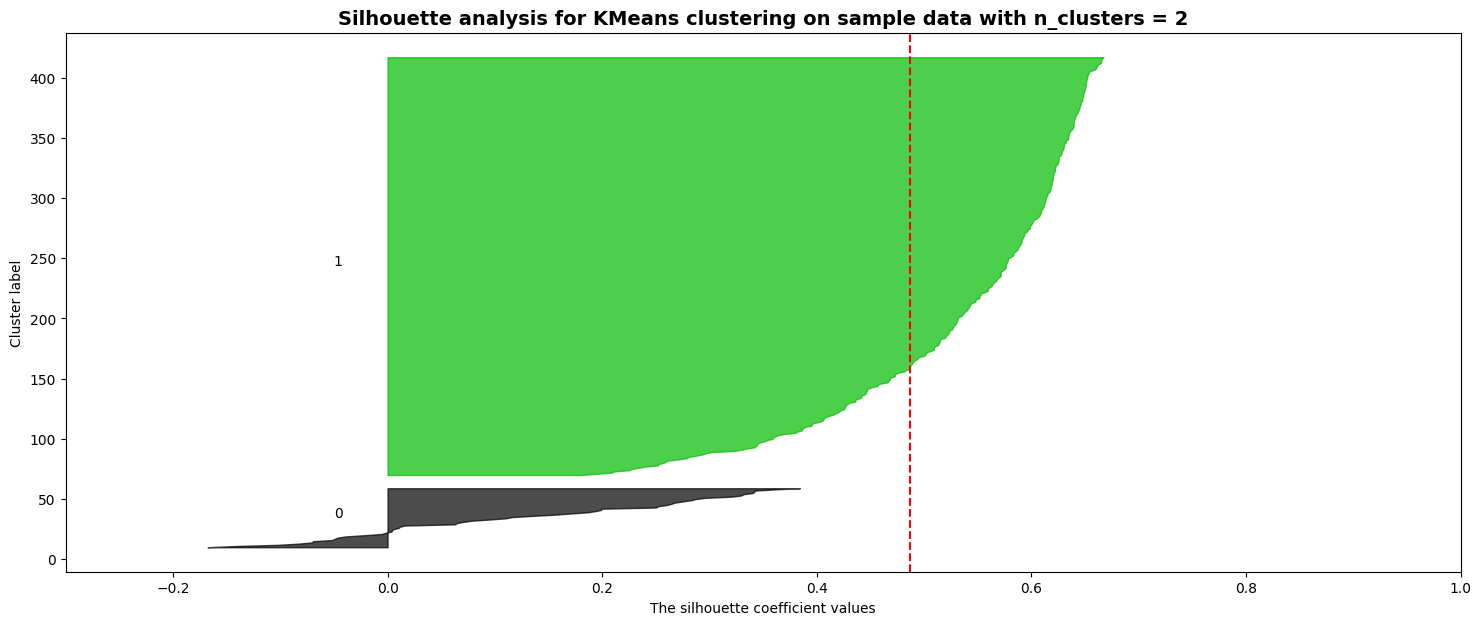

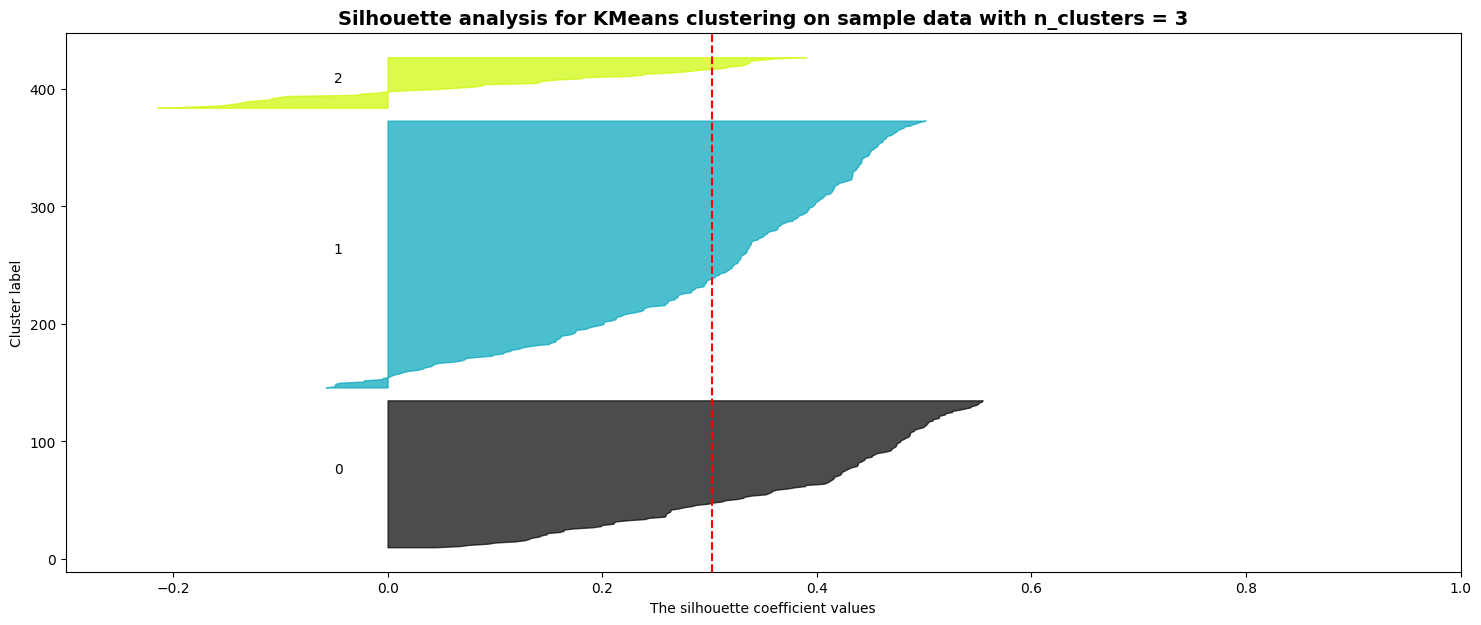

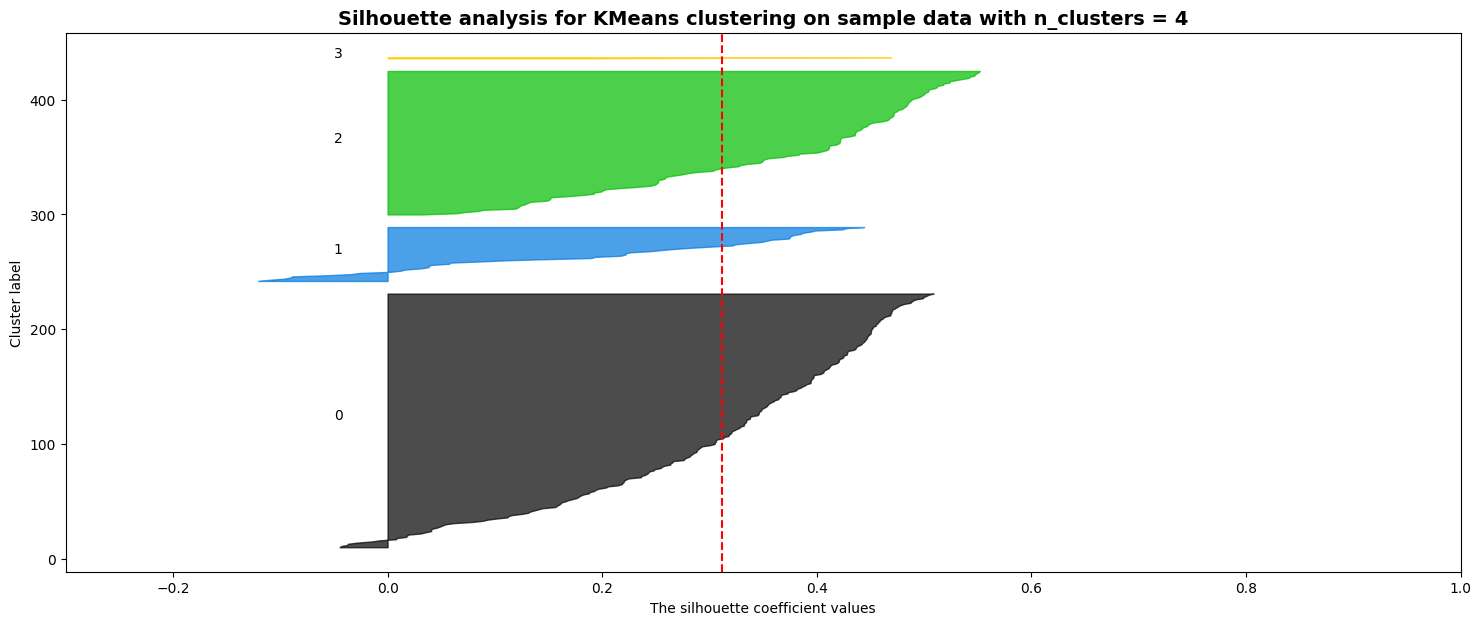

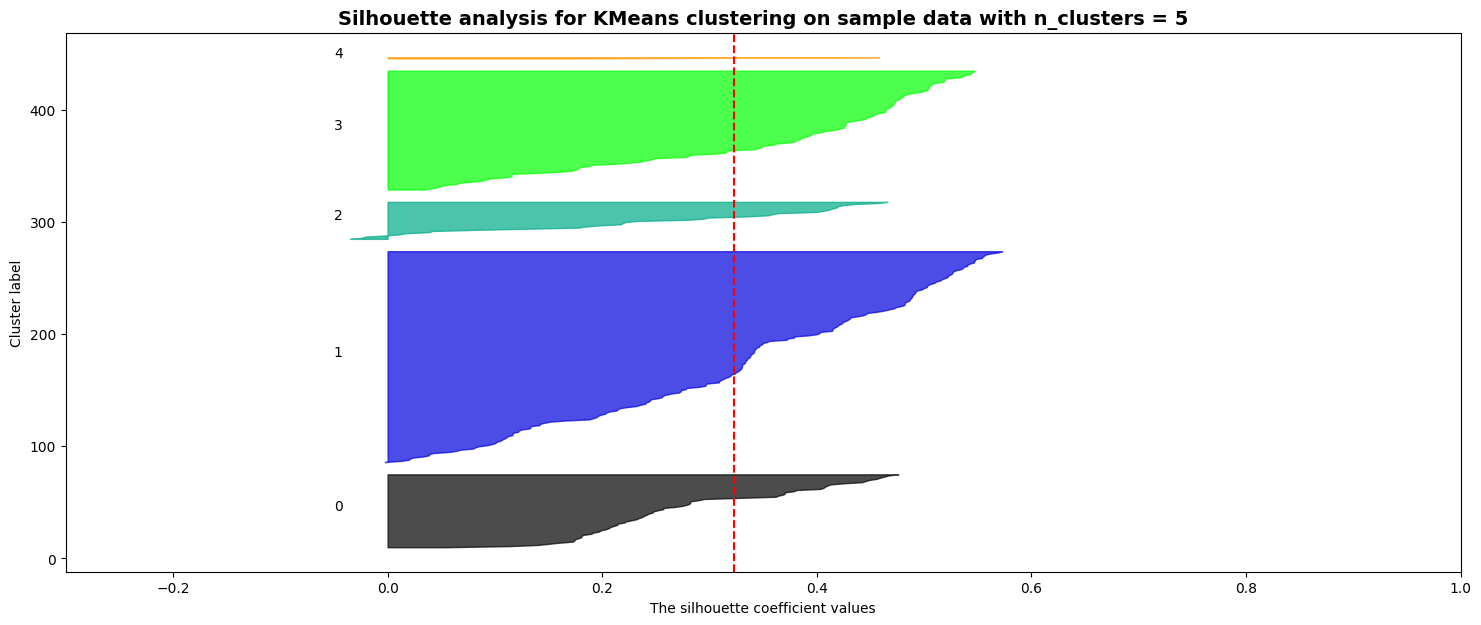

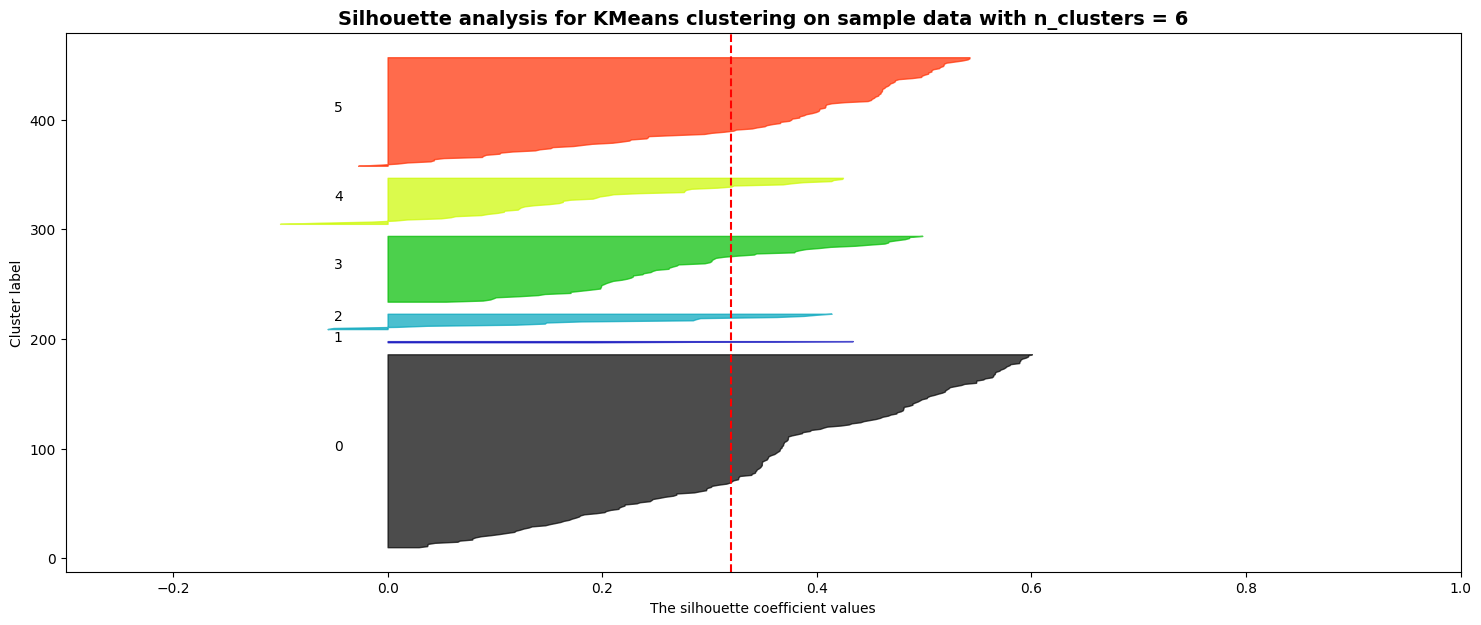

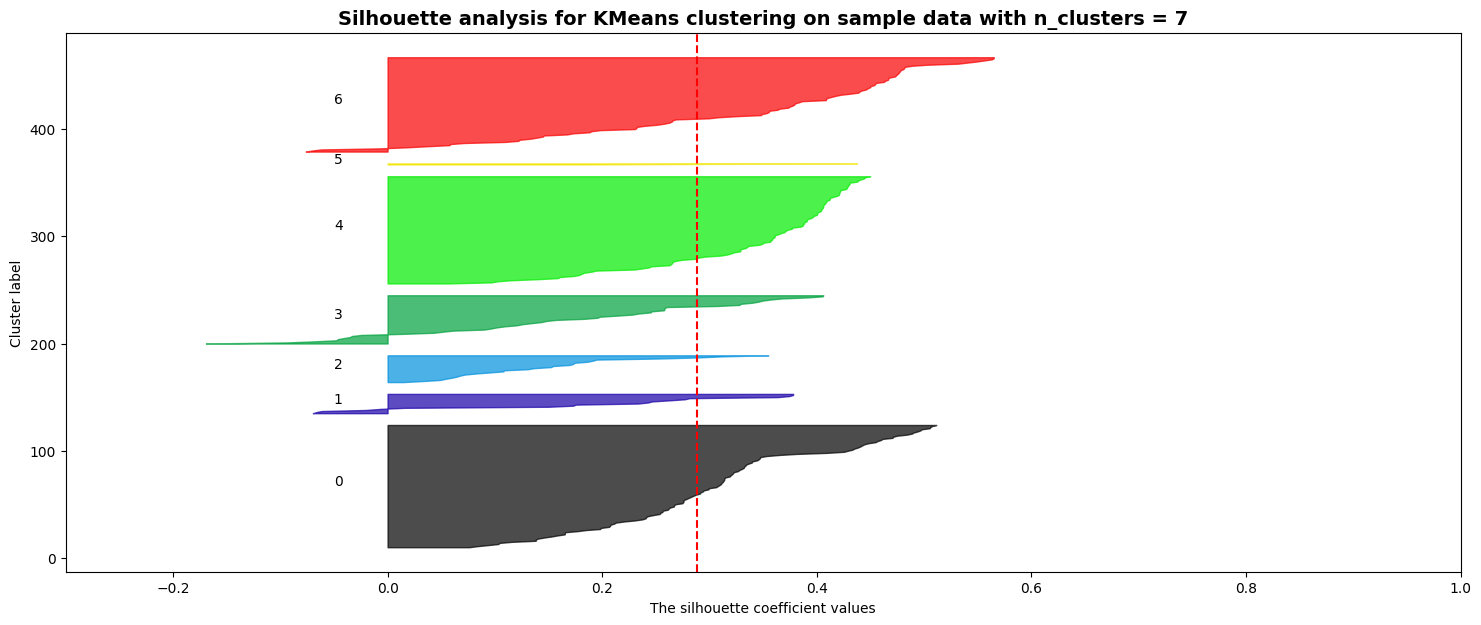

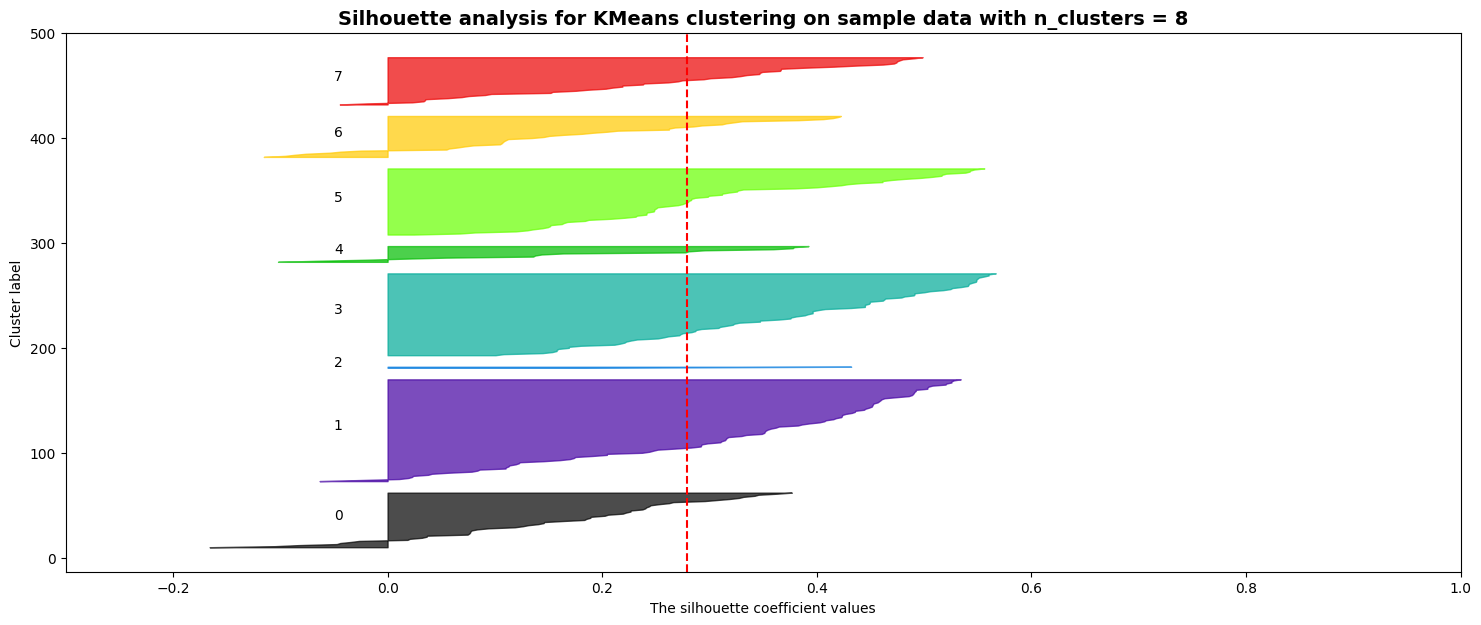

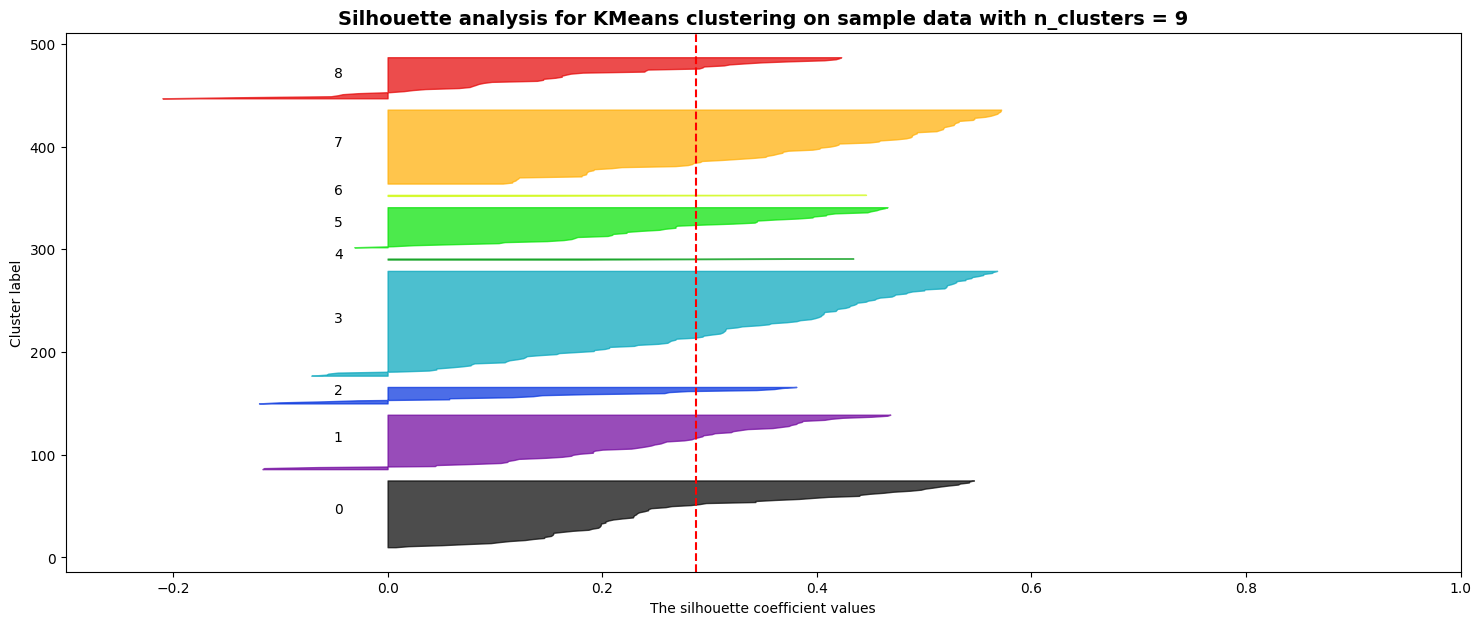

In [459]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for n_clusters in range_n_clusters:
    km7 = KMeans(n_clusters = n_clusters, n_init = 20, random_state=0)
    cluster_labels_km = km7.fit_predict(scaler_df)
    # average silhouette score
    silhouette_avg_km = silhouette_score(scaler_df, cluster_labels_km)
    # compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaler_df, cluster_labels_km)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.3, 1])# change this based on the silhouette range

    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_km == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            y=np.arange(y_lower, y_upper),
            x1=0,
            x2=ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next cluster silhouette scores
        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for various cluster")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg_km, color="red", linestyle="--")
    plt.title(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

$K = 2$ produces good clustering.

## 8. Data Splitting

In [460]:
df['class'] = df['class'].replace({'ckd': 1, 'notckd': 0})

/var/folders/81/yhrrszz97gz7w6ntdbgvchq80000gn/T/ipykernel_39441/2888872635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['class'].replace({'ckd': 1, 'notckd': 0})


In [461]:
df.isna().any()

age      False
bp       False
pcc      False
ba       False
bu       False
sc       False
htn      False
dm       False
cad      False
appet    False
pe       False
ane      False
class    False
dtype: bool

In [462]:
len(df)

398

In [463]:
X = df.drop(['class'], axis=1)

In [464]:
y = df['class']

In [465]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [466]:
X_train.head(5)

,age,bp,pcc,ba,bu,sc,htn,dm,cad,appet,pe,ane
289,-0.558813,-0.490210,0.0,0.0,-0.501298,-0.372524,0.0,0.0,0.0,1.0,0.0,0.0
202,1.563847,-1.232049,0.0,0.0,0.348639,-0.017633,0.0,1.0,0.0,1.0,0.0,1.0
104,0.207703,0.993468,0.0,0.0,0.631951,-0.177334,1.0,1.0,0.0,0.0,1.0,0.0
118,0.207703,-0.490210,0.0,0.0,-0.642954,-0.319290,0.0,0.0,0.0,0.0,1.0,0.0
267,-0.205036,0.251629,0.0,0.0,-0.481062,-0.372524,0.0,0.0,0.0,1.0,0.0,0.0


## 9. Classifier Choices

We note that there are a large number of numerical and categorical variables in this df, and to predict a binary in such a case, decision trees are a good choice because decision tree algorithms can handle mixed types of data. Also, decision trees have feature selection capability, which can improve the generalization ability and interpretability of the model. Therefore, decision tree is a very suitable algorithm.

Since the response variable is binary(ckd, notched), logistic regression is worth trying as well. It can easily handle categorical variables by using "OneHotEncoder", which allows it to handle a mix of numerical and categorical data. In our case, the data has many missing values even after cleaning there are still minor issues in data quality. The robustness of logistic regression can minimize the effectiveness of data quality issues.

## 10. Performance Matrixs

In [467]:
df_dt = DecisionTreeClassifier(
    max_depth = 30, 
    random_state=1
) 

In [468]:
df_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=30, random_state=1)

[Text(0.7297297297297297, 0.9642857142857143, 'sc <= -0.31\ngini = 0.47\nsamples = 278\nvalue = [105, 173]\nclass = ckd'),
 Text(0.5675675675675675, 0.8928571428571429, 'dm <= 0.5\ngini = 0.353\nsamples = 131\nvalue = [101, 30]\nclass = notckd'),
 Text(0.5135135135135135, 0.8214285714285714, 'pe <= 0.5\ngini = 0.267\nsamples = 120\nvalue = [101, 19]\nclass = notckd'),
 Text(0.4594594594594595, 0.75, 'age <= -2.328\ngini = 0.214\nsamples = 115\nvalue = [101, 14]\nclass = notckd'),
 Text(0.40540540540540543, 0.6785714285714286, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = ckd'),
 Text(0.5135135135135135, 0.6785714285714286, 'bp <= 0.993\ngini = 0.177\nsamples = 112\nvalue = [101, 11]\nclass = notckd'),
 Text(0.4594594594594595, 0.6071428571428571, 'age <= 1.652\ngini = 0.136\nsamples = 109\nvalue = [101, 8]\nclass = notckd'),
 Text(0.40540540540540543, 0.5357142857142857, 'ane <= 0.5\ngini = 0.121\nsamples = 108\nvalue = [101, 7]\nclass = notckd'),
 Text(0.35135135135135137, 0.46428

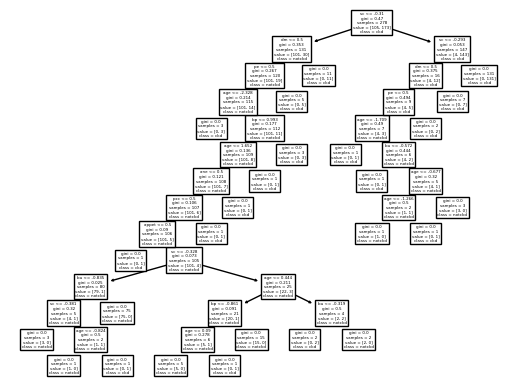

In [469]:
plot_tree(
    df_dt, 
    max_depth = 30, 
    feature_names = X_train.columns.tolist(), 
    class_names=['notckd', 'ckd']
)

In [470]:
pred = df_dt.predict(X_test)
pred[:5]

array([0, 1, 1, 1, 1])

In [471]:
cm = pd.DataFrame(confusion_matrix(y_test, pred), index=['notckd', 'ckd'], columns=['notckd', 'ckd'])
cm.index.name = 'True'
cm.columns.name = 'Predicted'
cm

Predicted,notckd,ckd
True,,
notckd,42,3
ckd,6,69


In [472]:
df_dt.score(X_test, y_test)

0.925

In [473]:
print(classification_report(y_test, pred))
print("Accuracy:", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        45
           1       0.96      0.92      0.94        75

    accuracy                           0.93       120
   macro avg       0.92      0.93      0.92       120
weighted avg       0.93      0.93      0.93       120

Accuracy: 0.925


In [474]:
path = df_dt.cost_complexity_pruning_path(
    X_train, 
    y_train
)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [475]:
clfs = [] # save fitted trees with different alphas
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=0, 
        ccp_alpha=ccp_alpha
        )
    clf.fit(X_train, y_train)
    clfs.append(clf)

test_score = [clf.score(X_test, y_test) for clf in clfs]

In [476]:
depth = [clf.tree_.max_depth for clf in clfs]
test_score = [clf.score(X_test, y_test) for clf in clfs]

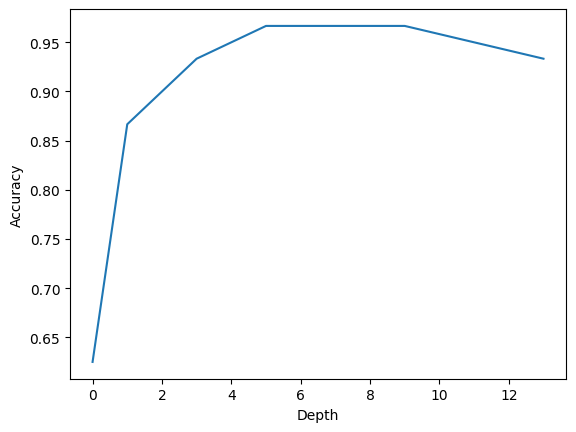

In [477]:
plt.plot(depth, test_score)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

Max accuracy at depth = 5

In [478]:
df_dt_best = DecisionTreeClassifier(
    max_depth = 5, 
    random_state=1
    ) 
df_dt_best.fit(X, y)

DecisionTreeClassifier(max_depth=5, random_state=1)

## Logistic Regression

In [479]:
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [480]:
formula = 'age+bp+C(pcc)+C(ba)+bu+sc+C(htn)+C(dm)+C(cad)+C(appet)+C(pe)+C(ane)'
X = dmatrix(formula, df, return_type='dataframe')
y = df['class']

In [481]:
y = df['class']
X = df.drop('class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

In [482]:
def_log = LogisticRegression()
def_log.fit(X_train, y_train)

LogisticRegression()

In [483]:
Predict = def_log.predict(X_test)
print("Accuracy:", accuracy_score(y_test, Predict))
print("Classification Report:\n", classification_report(y_test, Predict))

Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        44
           1       1.00      0.92      0.96        76

    accuracy                           0.95       120
   macro avg       0.94      0.96      0.95       120
weighted avg       0.96      0.95      0.95       120



In [484]:
matrix = confusion_matrix(y_test, Predict)
print("Confusion Matrix:\n", matrix)

Confusion Matrix:
 [[44  0]
 [ 6 70]]


The confusion matrix of the Decision tree model tells us there is a total of 120 observations. The model predicts 42 observations are notckd that is notckd, 6 of the observations model predict is notckd but it is ckd. Then the model predicted 69 observations of them are ckd that is are ckd, 3 of them model predicted is ckd but it is notckd

The confusion matrix of the logistic model tells us similar result. The model predicts 44 observations are notckd that is notckd, 6 of the observation model predict is notckd but it is ckd. Then the model correctly predicted all 70 of them are ckd, they are actually all ckd.

## 11. Feature Selection/Extraction

In [485]:
fea_imp = df_dt_best.feature_importances_

sorted_indices = fea_imp.argsort()[::-1]# read from the tail of the argsort to get greatest to least indices of the elements
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = fea_imp[sorted_indices]

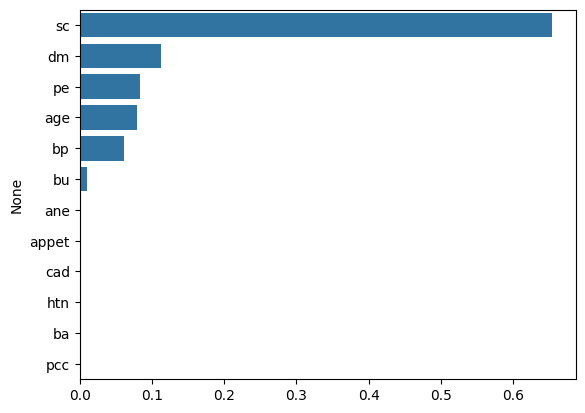

In [486]:
sns.barplot(x = sorted_importances, y = sorted_feature_names)
plt.show()

Among all the variables, sc is the most influential variable in decision tree operations, followed by dm, pe, age, bp and bu, and the other variables are relatively less influential

## 12. Classifier Comparison

Accuracy: 0.9833333333333333
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        44
           1       1.00      0.97      0.99        76

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120



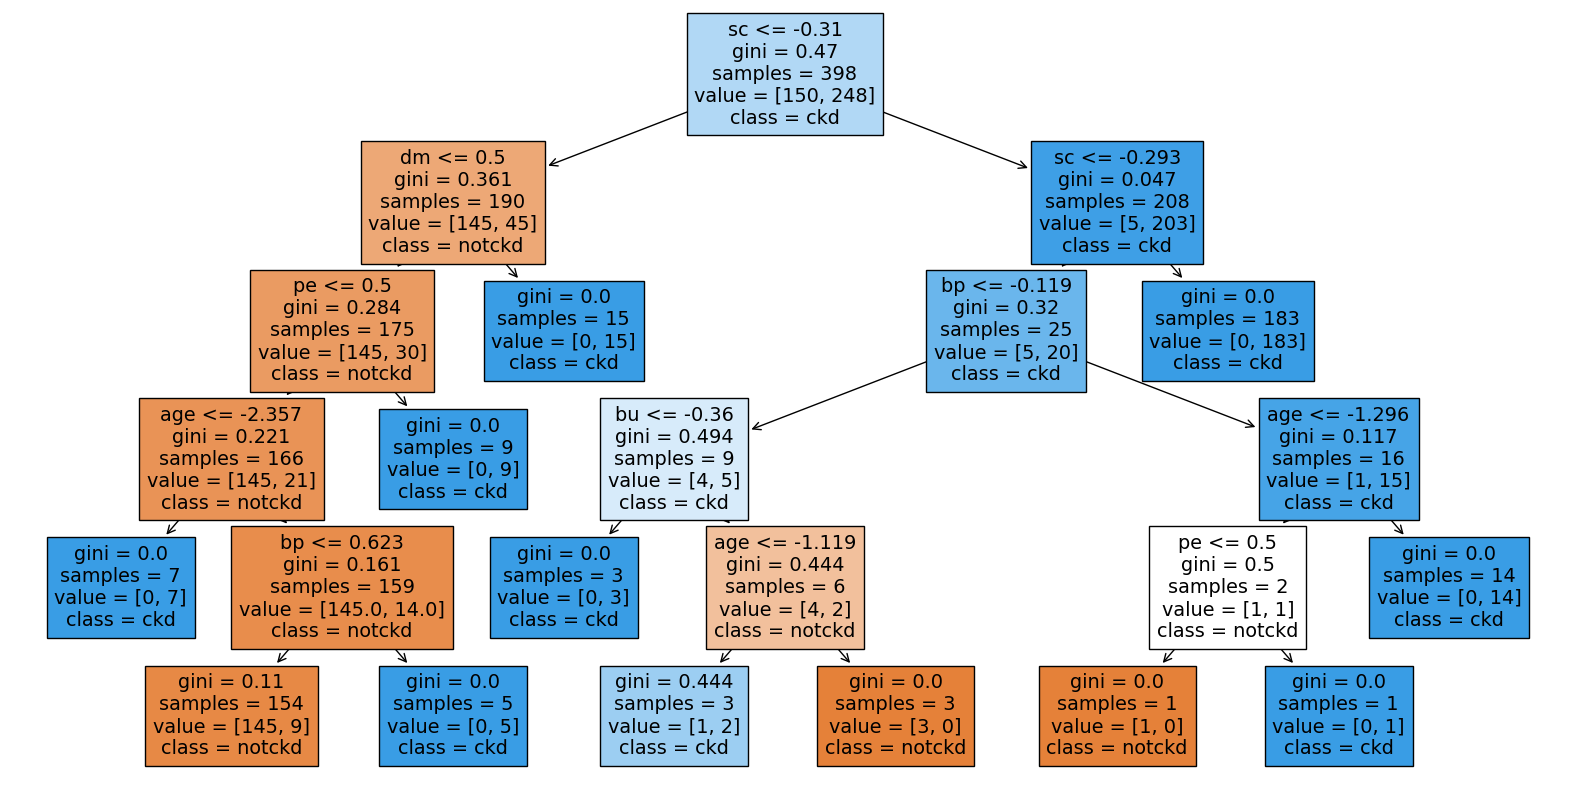

In [487]:
clf = DecisionTreeClassifier(max_depth = 5, 
    random_state=1) 

clf.fit(X, y)


y_pred = clf.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


plt.figure(figsize=(20,10))
plot_tree(clf, filled=True,feature_names = X_train.columns.tolist(),class_names=['notckd', 'ckd'])
plt.show()

## logistic regression

In [488]:
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [489]:
formula = 'age+bp+C(pcc)+C(ba)+bu+sc+C(htn)+C(dm)+C(cad)+C(appet)+C(pe)+C(ane)'
X = dmatrix(formula, df, return_type='dataframe')
y = df['class']

In [490]:
y = df['class']
X = df.drop('class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

In [491]:
X_train_transformed = dmatrix(formula, X_train, return_type='dataframe')
X_test_transformed = dmatrix(formula, X_test, return_type='dataframe')

In [492]:
def_log = LogisticRegression()
def_log.fit(X_train, y_train)

LogisticRegression()

In [493]:
Predict = def_log.predict(X_test)
print("Accuracy:", accuracy_score(y_test, Predict))
print("Classification Report:\n", classification_report(y_test, Predict))

Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        44
           1       1.00      0.92      0.96        76

    accuracy                           0.95       120
   macro avg       0.94      0.96      0.95       120
weighted avg       0.96      0.95      0.95       120



In [494]:
X_added = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_added)
result = logit_model.fit()
result.summary()

         Current function value: 0.152892
         Iterations: 35


/Users/itsmine/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  class   No. Observations:                  278
Model:                          Logit   Df Residuals:                      265
Method:                           MLE   Df Model:                           12
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:                  0.7700
Time:                        18:35:49   Log-Likelihood:                -42.504
converged:                      False   LL-Null:                       -184.79
Covariance Type:            nonrobust   LLR p-value:                 8.130e-54
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.3545   1.54e+06   2.36e-05      1.000   -3.02e+06    3.02e+06
age           -0.4809      0.289     -1.662      0.096      -1.048       0.086
bp             0.7797      0.377      2.067      0.039       0.040       1.519
pcc           15.4405   5471.608      0.003      0.998   -1.07e+04    1.07e+04
ba             4.1318   1.44e+07   2.87e-07      1.000   -2.82e+07    2.82e+07
bu            -0.6752      1.215     -0.556      0.578      -3.056       1.705
sc            21.7103      5.910      3.674      0.000      10.127      33.293
htn           18.9178   3276.811      0.006      0.995   -6403.514    6441.350
dm            27.0655    1.3e+05      0.000      1.000   -2.54e+05    2.54e+05
cad           -4.4796   5473.093     -0.001      0.999   -1.07e+04    1.07e+04
appet        -30.9248   1.54e+06  -2.01e-05      1.000   -3.02e+06    3.02e+06
pe            34.3144   2.76e+06   1.24e-05      1.000   -5.41e+06    5.41e+06
ane           22.4743    1.8e+04      0.001      0.999   -3.53e+04    3.53e+04
==============================================================================

Possibly complete quasi-separation: A fraction 0.54 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Finding:
1. The Decision tree model has 98.3 percent accuarcy, The Logistic regression has model has 95 percent accuarcy. 
2. Thought the test set not even Decision Tree model has higher accuarcy than the Logistic regression model, but also for the F-score and the prescisions for individual 1 and 0, Decision tree also has higher accuarcy than the logistic model. 

## 13 Interpretable Classifier Insight: 

In [495]:
formula = 'age+bp+C(pcc)+C(ba)+bu+sc+C(htn)+C(dm)+C(cad)+C(appet)+C(pe)+C(ane)'
X = dmatrix(formula, df, return_type='dataframe')
yT = df['class']

In [496]:
def_log = LogisticRegression()
def_log.fit(X, yT)

LogisticRegression()

In [497]:
TotalPredict = def_log.predict(X)
print("Accuracy:", accuracy_score(yT, TotalPredict))
print("Classification Report:\n", classification_report(yT, TotalPredict))

Accuracy: 0.9396984924623115
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93       150
           1       1.00      0.90      0.95       248

    accuracy                           0.94       398
   macro avg       0.93      0.95      0.94       398
weighted avg       0.95      0.94      0.94       398



In [498]:
X_added = sm.add_constant(X)
logit_model = sm.Logit(yT, X_added)
result_T = logit_model.fit()

         Current function value: 0.137624
         Iterations: 35


/Users/itsmine/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [499]:
print(result_T.summary())

                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  398
Model:                          Logit   Df Residuals:                      385
Method:                           MLE   Df Model:                           12
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:                  0.7923
Time:                        18:35:49   Log-Likelihood:                -54.775
converged:                      False   LL-Null:                       -263.68
Covariance Type:            nonrobust   LLR p-value:                 6.362e-82
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          27.4289   1.13e+04      0.002      0.998   -2.22e+04    2.23e+04
C(pcc)[T.1.0]      18.1362   6342.652      0.003      0.998   -1.24e+04    1.24e+04
C(ba)[T.1.0]        1.2587   985

1. After I retrained the model for all avaliable data R square increase 2 percent, which means the goodness of the fit increase by 2 percent possibily cause by 30 percent more observation increase.  
2. Significance of variables stays the same, only age, bp, and sc are statistically significant. With this many insignificant variables we concern the model can cause bad performance on the unseen data. 

https://github.com/huanj164/Assignment_6.git